In [1]:
#ロケットのタイムステップは100
ts.length <- 100

In [5]:
# 運動は加速度で駆動される
a <- rep(0.5, ts.length)

In [6]:
#　位置と速度の初期値は0
x <- rep(0, ts.length)
v <- rep(0, ts.length)

for (ts in 2:ts.length){
    x[ts] <- v[ts-1]*2 + x[ts-1] + 1/2 * a[ts-1] ^2
    x[ts] <- v[ts] + rnorm(1, sd = 20)# 確率論的成分
    v[ts] <- v[ts-1] + 2 * a[ts-1]
}

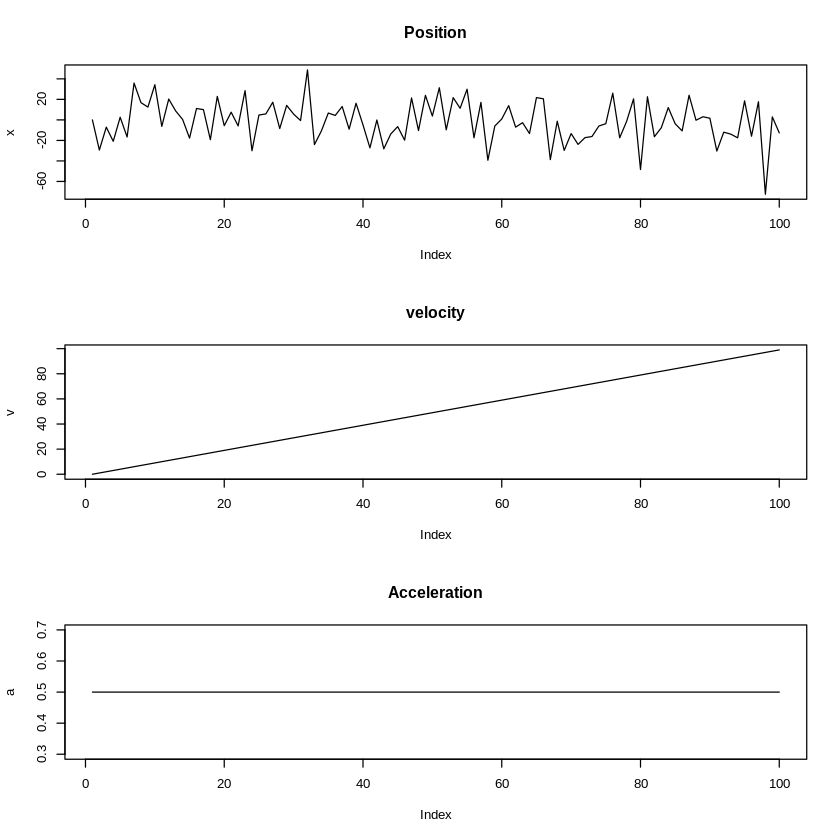

In [7]:
par(mfrow = c(3,1))
plot(x, main = "Position", type = "l")
plot(v, main = "velocity", type = "l")
plot(a, main = "Acceleration", type = "l")

### 　　　　Fig.7-1 ロケットの位置と速度と加速度

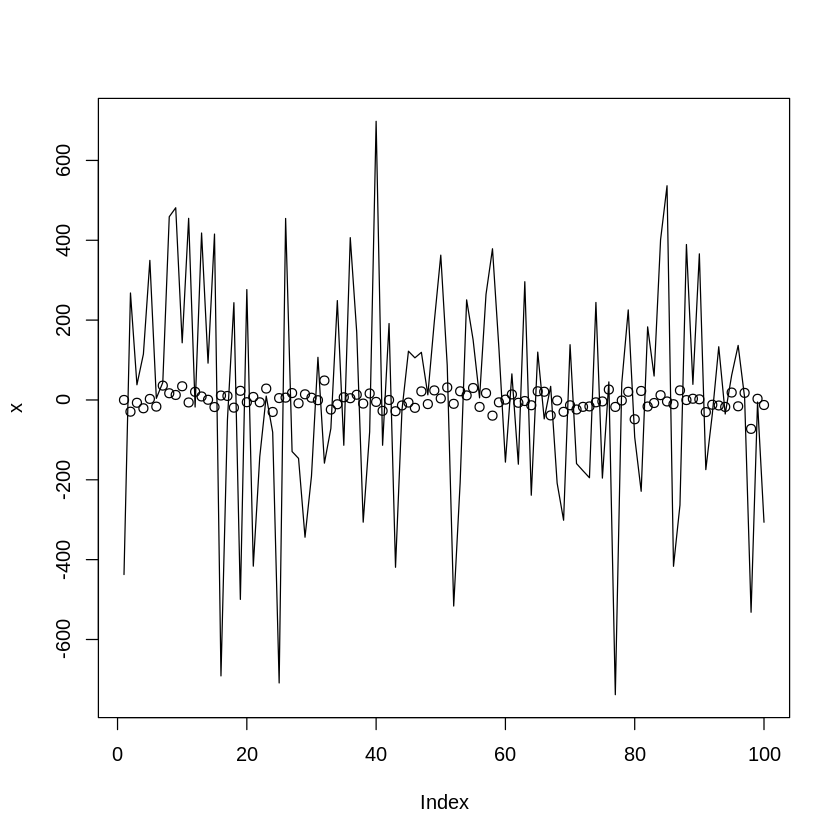

In [8]:
z <- x + rnorm(ts.length, sd = 300)
plot(x, ylim = range(c(x,z)))
lines(z)

In [9]:
###  Fig.7-2 真の位置(点)　対　ノイズの多い観測線(線)

In [18]:
kalman.motion <- function(z, Q, R, A, H){
    dimState = dim(Q)[1]
    
    xhatminus <- array(rep(0, ts.length * dimState), 
                  c(ts.length, dimState))
    
    xhat <- array(rep(0, ts.length * dimState), 
                  c(ts.length, dimState))
    
    Pminus <- array(rep(0, ts.length*dimState*dimState),
                    c(ts.length, dimState, dimState))
    
    P <- array(rep(0, ts.length * dimState * dimState),
              c(ts.length, dimState, dimState))
    K <- array(rep(0, ts.length * dimState * dimState),
              c(ts.length, dimState))#カルマンゲイン
    
    #　初期値の設定。全ての指標を０で開始
    xhat[1,] <- rep(0, dimState)
    P[1, , ] <- diag(dimState)
    
    for (k in 2:ts.length) {
      # 時間の更新
      xhat[1, ] <- A %*% matrix(xhat[k-1,])
      Pminus[k, ,] <- A %*% P[k-1, , ] %*% t(A) + Q
        
      K[k, ] <- Pminus[k, , ] %*% H %*%
        solve( t(H) %*% Pminus[k, , ] %*% H + R )
      xhat[k, ] <- xhatminus[k, ] + K[k, ] %*%
        (z[k] - t(H) %*% xhatminus[k, ])
    P[k, , ] <- (diag(dimState)-K[k,] %*% t(H)) %*% Pminus[k, , ]
    }
    
    # 予測と平滑化した値の両方を返す
    return(list(xhat= xhat, xhatminus = xhatminus))
    
    }

In [20]:
# ノイズのパラメータ
R <- 10^2 #観測の分散。
        　　　　#この値は観測機器の既知の物理的な限界に応じて設定すべき。
          # 上のデータ生成ではxに加えたノイズと整合性があるように設定。
Q <- 10 # 過程の分散。
　　　　　　　　　　　　　　　　# 通常は性能を最大にするように調整するハイパーパラメータと見做される。

# ダイナミクス
A <- matrix(1) # x_t = A * x_t-1 (前のxが後々のxにどう影響を及ぼすか。)
H <- matrix(1) # y_t = H * x_t (状態を観測値に変換する)

# カルマンフィルタ手法にデータを通す。
xhat <- kalman.motion(z, diag(1) * Q, R, A, H)[[1]]

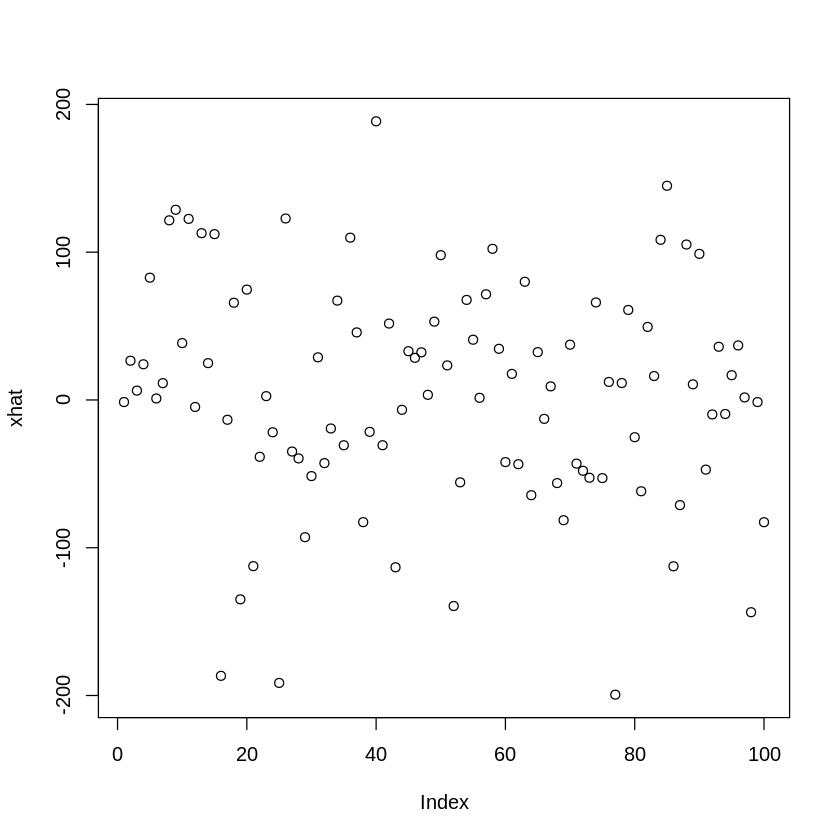

In [23]:
## 発表者メモ: テキストP207の図7-3を表示したいですが、Rの記法がわかっていないため、図7-3を再現できておりません
plot(xhat)

## 7.3 隠れマルコフモデル
### 7.3.3 コードを使ってHMMを当てはめる。

In [26]:
# テキストP214
# この事例では、乱数を固定するためにシードを設定する。
# 同じシードを設定すれば、数値を一致するはず
set.seed(123)

# 表したい市場の４つの状態の各々のパラメータを設定する。
bull_mu <- 0.1
bull_sd <- 0.1

neutral_mu <- 0.02
neutral_sd <- 0.08

bear_mu <- 0.03
bear_sd <- 0.2

panic_mu <- 0.1
panic_sd <- 0.3

# インデックス化しやすいようにパラメータをベクトルにまとめる。
mus <- c(bull_mu, neutral_mu, bear_mu, panic_mu)
sds <- c(bull_sd, neutral_sd, bear_sd, panic_sd)

# 生成する時系列を記述する定数を設定する。
NUM.PERIODS <- 10
SMALLEST.PERIOD <- 20
LONGEST.PERIOD <- 40

# 日数の数列を確率論的に決定する。
# 各日数は市場の状態の１つが継続する長さを表す。
days <- sample(SMALLEST.PERIOD:LONGEST.PERIOD, NUM.PERIODS, replace=TRUE)

# 日数ベクトルの各日数について
# 特定の市場の状態が続く日数の時系列を生成し
# 全体の時系列に加える

returns <- numeric()
true.mean <- numeric()

for (d in days) {
    idx = sample(1:4, 1, prob = c(0.2, 0.6, 0.18, 0.02))
    returns <- c(returns, rnorm(d, mean = mus[idx], sd = sds[idx]))
    true.mean <- c(true.mean, rep(mus[idx], d))
}

In [27]:
table(true.mean)
true.mean

true.mean
0.02 0.03  0.1 
 142   66  111 

[1] 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10
 [16] 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10
 [31] 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10
 [46] 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10
 [61] 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.02 0.02 0.02
 [76] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 [91] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
[106] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
[121] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
[136] 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
[151] 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
[166] 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
[181] 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.02 0.02
[196] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
[211] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
[226] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
[241] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10
[256] 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10
[271] 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10
[286] 0.10 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
[301] 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
[316] 0.02 0.02 0.02 0.02

In [31]:
#　テキストP216
#install.packages("depmixS4") #必要があればコメントアウトを外してdepmixS4をインストール。
require(depmixS4)

hmm.model <- depmix(returns ~ 1, family = gaussian(),
                   nstates = 4, data = data.frame(returns=returns))
model.fit <- fit(hmm.model)
post_probs <- posterior(model.fit)

Loading required package: depmixS4

Loading required package: nnet

Loading required package: MASS

Loading required package: Rsolnp

Loading required package: nlme

Warning message in .local(object, ...):
“Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options.”


In [32]:
post_probs

state,S1,S2,S3,S4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.000000e+00,0.000000e+00,1.00000000,0.000000000
3,1.543087e-03,0.000000e+00,0.66210159,0.336355324
4,7.055065e-02,3.122214e-05,0.18866989,0.740748236
3,1.175838e-03,6.080925e-04,0.91531995,0.082896120
3,9.896990e-03,2.847265e-04,0.66397835,0.325839936
4,2.406861e-05,1.302948e-03,0.44993273,0.548740250
3,5.239789e-03,7.270297e-04,0.80545765,0.188575527
3,1.655301e-02,3.838625e-04,0.64228136,0.340781763
4,7.295064e-02,4.999579e-04,0.37331140,0.553238004


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
NULL

[[103]]
NULL

[[104]]
NULL

[[105]]
NULL

[[106]]
NULL

[[107]]
NULL

[[108]]
NULL

[[109]]
NULL

[[110]]
NULL

[[111]]
NULL

[[112]]
NULL

[[113]]
NULL

[[114]]
NULL

[[115]]
NULL

[[116]]
NULL

[[117]]
NULL

[[118]]
NULL

[[119]]
NULL

[[120]]
NULL

[[121]]
NULL

[[122]]
NULL

[[123]]
NULL

[[124]]
NULL

[[125]]
NULL

[[126]]
NULL

[[127]]
NULL

[[128]]
NULL

[[129]]
NULL

[[130]]
NULL

[[131]]
NULL

[[132]]
NULL

[[133]]
NULL

[[134]]
NULL

[[135]]
NULL

[[136]]
NULL

[[137]]
NULL

[[138]]
NULL

[[139]]
NULL

[[140]]
NULL

[[141]]
NULL

[[142]]
NULL

[[143]]
NULL

[[144]]
NULL

[[145]]
NULL

[[146]]
NULL

[[147]]
NULL

[[148]]
NULL

[[149]]
NULL

[[150]]
NULL

[[151]]
NULL

[[152]]
NULL

[[153]]
NULL

[[154]]
NULL

[[155]]
NULL

[[156]]
NULL

[[157]]
NULL

[[158]]
NULL

[[159]]
NULL

[[160]]
NULL

[[161]]
NULL

[[162]]
NULL

[[163]]
NULL

[[164]]
NULL

[[165]]
NULL

[[166]]
NULL

[[167]]
NULL

[[168]]
NULL

[[169]]
NULL

[[170]]
NULL

[[171]]
NULL

[[172]]
NULL

[[173]]
NULL

[[174]]
NULL

[[175]]
NULL

[[176]]
NULL

[[177]]
NULL

[[178]]
NULL

[[179]]
NULL

[[180]]
NULL

[[181]]
NULL

[[182]]
NULL

[[183]]
NULL

[[184]]
NULL

[[185]]
NULL

[[186]]
NULL

[[187]]
NULL

[[188]]
NULL

[[189]]
NULL

[[190]]
NULL

[[191]]
NULL

[[192]]
NULL

[[193]]
NULL

[[194]]
NULL

[[195]]
NULL

[[196]]
NULL

[[197]]
NULL

[[198]]
NULL

[[199]]
NULL

[[200]]
NULL

[[201]]
NULL

[[202]]
NULL

[[203]]
NULL

[[204]]
NULL

[[205]]
NULL

[[206]]
NULL

[[207]]
NULL

[[208]]
NULL

[[209]]
NULL

[[210]]
NULL

[[211]]
NULL

[[212]]
NULL

[[213]]
NULL

[[214]]
NULL

[[215]]
NULL

[[216]]
NULL

[[217]]
NULL

[[218]]
NULL

[[219]]
NULL

[[220]]
NULL

[[221]]
NULL

[[222]]
NULL

[[223]]
NULL

[[224]]
NULL

[[225]]
NULL

[[226]]
NULL

[[227]]
NULL

[[228]]
NULL

[[229]]
NULL

[[230]]
NULL

[[231]]
NULL

[[232]]
NULL

[[233]]
NULL

[[234]]
NULL

[[235]]
NULL

[[236]]
NULL

[[237]]
NULL

[[238]]
NULL

[[239]]
NULL

[[240]]
NULL

[[241]]
NULL

[[242]]
NULL

[[243]]
NULL

[[244]]
NULL

[[245]]
NULL

[[246]]
NULL

[[247]]
NULL

[[248]]
NULL

[[249]]
NULL

[[250]]
NULL

[[251]]
NULL

[[252]]
NULL

[[253]]
NULL

[[254]]
NULL

[[255]]
NULL

[[256]]
NULL

[[257]]
NULL

[[258]]
NULL

[[259]]
NULL

[[260]]
NULL

[[261]]
NULL

[[262]]
NULL

[[263]]
NULL

[[264]]
NULL

[[265]]
NULL

[[266]]
NULL

[[267]]
NULL

[[268]]
NULL

[[269]]
NULL

[[270]]
NULL

[[271]]
NULL

[[272]]
NULL

[[273]]
NULL

[[274]]
NULL

[[275]]
NULL

[[276]]
NULL

[[277]]
NULL

[[278]]
NULL

[[279]]
NULL

[[280]]
NULL

[[281]]
NULL

[[282]]
NULL

[[283]]
NULL

[[284]]
NULL

[[285]]
NULL

[[286]]
NULL

[[287]]
NULL

[[288]]
NULL

[[289]]
NULL

[[290]]
NULL

[[291]]
NULL

[[292]]
NULL

[[293]]
NULL

[[294]

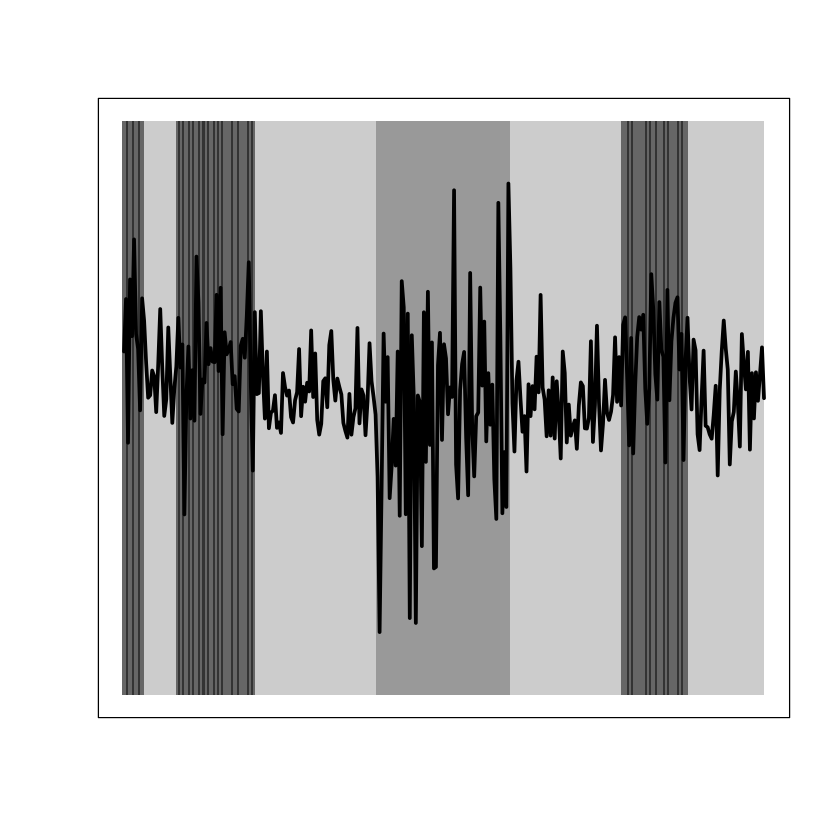

In [52]:
# テキストP216
plot(returns, type = 'l', lwd = 3, col = 1,
    yaxt = "n", xaxt="n",xlab="", ylab="",
    ylim=c(-0.6, 0.6))

# テキストの誤植？　0:(length(returns)-1, function (i)と記載があったが、エラーが出たため以下のように修正。
# 正誤表にも記載なし。https://www.oreilly.com/catalog/errata.csp?isbn=0636920187714
lapply(0:(length(returns) - 1), function (i) {
    #　背景に適切な色の長方形を追加して
    # 任意のタイムステップにおける状態を表す。
    rect(i, -0.6, (i+1), 0.6,
         col = rgb(0.0, 0.0, 0.0, alpha=(0.2 * post_probs$state[i+1])),
         border = NA)
})

### 7.4 ベイズ構造時系列モデル
#### 7.4.1 bsts用のコード

In [1]:
# テキストP219
#install.packages("bsts")
#install.packages("data.table")
require(data.table)
#elec = fread("electric.csv")

# freadの中に、ファイル名をrootディレクトリからフルパスで入力する。
elec = fread("AirportPassangers.csv")
getwd()
require(bsts)

Loading required package: data.table



ERROR: Error in fread("AirportPassangers.csv"): File 'AirportPassangers.csv' does not exist or is non-readable. getwd()=='/home/jovyan/work/notebooks/Ch07'


In [3]:
# テキストP220
n = columns(elec)[9]
par(mflow = c(2,1))
plot(elec[[n]][1:4000])
plot(elec[[n]][1:96])          

ERROR: Error in columns(elec): could not find function "columns"


In [ ]:
# テキストP220
ss <- AddLocalLinearTrend(list(), elec[[n]])
ss <- AddSeasonal(ss, elec[[n]], nseasons = 24, season.duration = 1)
ss <- AddSeasonal(ss, elec[[n]], nseasons = 7, season.duration = 24)

In [ ]:
# テキストP220
model1 <- bsts(elec[[n]],
               state.specification = ss,
               niter = 100)
plot(model1, xlim) = c(1800, 1900)

In [ ]:
plot(model1, "seasonal", nseasons = 7, season.duration=24)